In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
sys.path.append(os.path.abspath("../../LHAPDF-files/"))
from tools import PDFs
import matplotlib.pyplot as plt
import numpy as np
import lhapdf
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import scipy.optimize
import math
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import scipy

In [ ]:
class CJCTEQParam (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__(xmin, xmax)
        self.paramDict = {
            'uv1': 0.6133648035014467, 'uv2': 3.499104933721092, 'uv3': 1.1036260549621213, 'uv4': 2.2988893198409364, 'uv5':0.0,
            'dv1': 0.6402686704958147, 'dv2': 4.2566973342530146, 'dv3': 1.515849908638605, 'dv4': 0.41041651185296457, 'dv5' :0.0,
            'gsum': 0.3875768740070521, 'g1': 0.4005258278080356, 'g2': 4.938177163392509, 'g3': -3.15647890069442, 'g4': 3.053389537761821, "g5":0.0,
            'ubdb1': -0.16427041217808402, 'ubdb2': 6.240983768029569, 'ubdb3': 2.5405802326395293, 'ubdb4': -2.0300468513089767, 'ubdb5' : 0.0,
            'ssbsum': 0.4973835057947211, 'ssb1': -0.19494546482594588, 'ssb2': 8.1234996238736, 'ssb3': 1.0512785614013824, 'ssb4': 0.0, 'ssb5':0.0,
            'dboub0': -3.366913079434507, 'dboub1': 0.7908577859873195, 'dboub2': -0.30411797546052366, 'dboub3': 6.79224832409927, 'dboub4': 4.854053251269719
        }
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def getXF(self, x, flv) : 
        y=x**0.5     
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*np.e**(self.paramDict["uv3"]*x)*(1+np.e**self.paramDict["uv4"]*x)**self.paramDict["uv5"]
            #return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*y + self.paramDict["uv4"]*y**2+ self.paramDict["uv5"]*y**4 )
        elif flv=="dv" : 
            return self.paramNorm["dv0"]*x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*np.e**(self.paramDict["dv3"]*x)*(1+np.e**self.paramDict["dv4"]*x)**self.paramDict["dv5"]
            #return self.paramNorm["dv0"]*x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*y + self.paramDict["dv4"]*y**2+ self.paramDict["dv5"]*y**4)
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1+self.paramDict["g3"]*y+self.paramDict["g4"]*y**2+self.paramDict["g5"]*y**3)
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.exp(1+self.paramDict["ssb3"]*y+self.paramDict["ssb4"]*y**2+self.paramDict["ssb5"]*y**3)
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*y+self.paramDict["ubdb4"]*y**2+self.paramDict["ubdb5"]*y**4)
        elif flv=="dboub" : 
            return np.e**self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"] + 1+ self.paramDict["dboub3"]*x*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

In [145]:
def is_float(n):
    try:
        float(n)   # Type-casting the string to `float`.
                   # If string is not a valid `float`, 
                   # it'll raise `ValueError` exception
    except TypeError:
        return False
    return True

def bernstein(x, i, n) : 
    assert (i<=n)
    return scipy.special.binom(n, i) * x**i * (1-x)**(n-i)

class ParameterizationBase: 
    def __init__(self,xmin, xmax) : 
        self.xmin=xmin
        self.xmax=xmax
        self.paramDict=None
        self.paramNorm = {
            "uv0": 1, "dv0":1, "g0":1, "ssb0":1, "ubdb0":1
        }
        self.paramNames =None

    def getXF(self, x, flv) : 
        pass

    def getXFlist(self, xlist, flv) : 
        return np.array([self.getXF(x, flv) for x in xlist])

    def getF(self, x, flv) : 
        return self.getXF(x, flv)/x

    def sumRuleEval (self) : 
        lim = 100000
        self.paramNorm["uv0"] =1.0
        res = integrate.quad(self.getF, self.xmin, self.xmax, "uv", limit=lim)
        self.paramNorm["uv0"] =2/(res[0])

        self.paramNorm["dv0"] =1.0
        res = integrate.quad(self.getF, self.xmin, self.xmax, "dv", limit=lim)
        self.paramNorm["dv0"] =1/(res[0])
        #################################
        mom_uv = integrate.quad(self.getXF, self.xmin, self.xmax, "uv", limit=lim)[0]
        mom_dv = integrate.quad(self.getXF, self.xmin, self.xmax, "dv", limit=lim)[0]

        self.paramNorm["g0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "g", limit=lim)
        self.paramNorm["g0"] =self.paramDict["gsum"]/(res[0])

        rem = 1-mom_uv-mom_dv-self.paramDict["gsum"]
        self.paramNorm["ssb0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "ssb", limit=lim)
        self.paramNorm["ssb0"] =self.paramDict["ssbsum"]*rem/(3*res[0])

        rem = rem - self.paramDict["ssbsum"]*rem/3

        self.paramNorm["ubdb0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "ubdb", limit=lim)
        self.paramNorm["ubdb0"] = rem/(2*res[0])
        """
        
        flvs = ["tbar", "bbar", "cbar", "sbar", "ubar", "dbar","g", "d", "u", "s", "c", "b", "t"]
        #flvs = ["uv", "dv", "ssb", "g", "ubdb"]
        momsum =0
        for flv in flvs : 
            mom = integrate.quad(self.getXF, self.xmin, self.xmax, flv, limit=lim)[0]
            if (flv!="ubdb") :
                momsum=momsum + mom
            else :    
                momsum=momsum + 2*mom
        if (abs(1.0-momsum)>0.01) : 
            raise NotImplementedError("Violation of mom sum!")
        #print("Momentum sum : ", momsum)     
        """
        #print(self.paramNorm)
    def setParameter(self, name, val) :
        assert(len(name)==len(val))
        for key, item in zip(name, val): 
            self.paramDict[key] = item 
        self.sumRuleEval()

class CJ15Param (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__(xmin, xmax)
        self.paramDict = {'uv1': 0.61537,
                        'uv2': 3.5433,
                        'uv3': 0.0,
                        'uv4': 3.4609,
                        'dv1': 1.1595,
                        'dv2': 6.5514,
                        'dv3': -3.5030,
                        'dv4': 4.6787,
                        'dv5': 0.0036,
                        'dv6': 2.0,
                        'gsum': 0.3887,
                        'g1':  0.60307,
                        'g2':  6.4812,
                        'g3': -3.3064,
                        'g4':  3.1721,
                        'ubdb1': -0.20775,
                        'ubdb2': 8.3286,
                        'ubdb3': 0.0,
                        'ubdb4': 14.606,
                        'ssbsum': 0.50002,
                        'ssb1': -0.20775,
                        'ssb2':  8.3286,
                        'ssb3':  0.0,
                        'ssb4': 14.606,
                        'dboub0': 35712,
                        'dboub1': 4.0249,
                        'dboub2': 20.154,
                        'dboub3': 17,
                        'dboub4': 51.156}
        
        
        '''
                     


                        {'uv1': 0.6354591378057833,
                        'uv2': 3.550214566573523,
                        'uv3': -0.013498056171166244,
                        'uv4': 3.0821599564720734,
                        'dv1': 1.1771755671362898,
                        'dv2': 7.117165170472524,
                        'dv3': -3.8712441239843742,
                        'dv4': 5.352106411349545,
                        'dv5': 0.0028922945738340576,
                        'dv6': 0.28514750898673663,
                        'gsum': 0.38736426755312625,
                        'g1': 0.6795636705129292,
                        'g2': 5.401732012291753,
                        'g3': -5.128580236308802,
                        'g4': 9.951544754362105,
                        'g5': -6.576705447821018,
                        'ubdb1': -0.2144994505256356,
                        'ubdb2': 8.240861937929283,
                        'ubdb3': -0.018789384258679334,
                        'ubdb4': 15.215199717560584,
                        'ssbsum': 0.4997945461617584,
                        'ssb1': -0.21429679950502095,
                        'ssb2': 8.24158976518661,
                        'ssb3': -0.03712141316832647,
                        'ssb4': 15.216936476836553,
                        'dboub0': 52643.39568081009,
                        'dboub1': 4.178221100422053,
                        'dboub2': 19.651067197393733,
                        'dboub3': 17.091872465757124,
                        'dboub4': 62.340837641899775}
        '''
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*x**0.5+self.paramDict["uv4"]*x)
        elif flv=="dv" : 
            if (self.paramNorm['uv0']==1.0) : 
                print("Warning : uv is not normalized!")
            return self.paramNorm["dv0"]*(x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*x**0.5+self.paramDict["dv4"]*x) + self.paramDict["dv5"]*x**self.paramDict["dv6"]*self.getXF(x, "uv") )
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1+self.paramDict["g3"]*x**0.5+self.paramDict["g4"]*x)
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*(1+self.paramDict["ssb3"]*x**0.5+self.paramDict["ssb4"]*x)
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*x**0.5+self.paramDict["ubdb4"]*x)
        elif flv=="dboub" : 
            return self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"] + 1+ self.paramDict["dboub3"]*x*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

class CJ15ParamNoSumRule (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__(xmin, xmax)
        self.paramDict ={'uv0': 2.4067,
                        'uv1': 0.61537,
                        'uv2': 3.5433,
                        'uv3': 0.0,
                        'uv4': 3.4609,
                        'dv0': 24.684,
                        'dv1': 1.1595,
                        'dv2': 6.5514,
                        'dv3': -3.5030,
                        'dv4': 4.6787,
                        'dv5': 0.0036,
                        'dv6': 2.0,
                        'g0': 45.542,
                        'g1': 0.60307,
                        'g2': 6.4812,
                        'g3': -3.3064,
                        'g4': 3.1721,
                        'ubdb0': 0.1466,
                        'ubdb1': -0.20775,
                        'ubdb2': 8.3286,
                        'ubdb3': 0.0,
                        'ubdb4': 14.606,
                        'dboub0': 35712,
                        'dboub1': 4.0249,
                        'dboub2': 20.154,
                        'dboub3': 17,
                        'dboub4': 51.156}
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def sumRuleEval(self) : 
        pass

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramDict["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*x**0.5+self.paramDict["uv4"]*x)
        elif flv=="dv" : 
            return self.paramDict["dv0"]*(x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*x**0.5+self.paramDict["dv4"]*x) + self.paramDict["dv5"]*x**self.paramDict["dv6"]*self.getXF(x, "uv") )
        elif flv=="g" : 
            g0= self.paramDict["g0"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1.0+self.paramDict["g3"]*x**0.5+self.paramDict["g4"]*x)
        elif flv=="ubdb" : 
            return self.paramDict["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*x**0.5+self.paramDict["ubdb4"]*x)
        elif flv=="ssb" : 
            #s0 = self.paramDict["ssb0"]
            return 0.4*self.getXF(x, "ubdb") #s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*(1+self.paramDict["ssb3"]*x**0.5+self.paramDict["ssb4"]*x)
        elif flv=="dboub" : 
            return self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"] + 1+ self.paramDict["dboub3"]*x*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

class CTEQParam (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__( xmin, xmax)
        self.paramDict={
            "uv1":0.63002, "uv2" : 2.93351, "uv3":-2.36916, "uv4":1.26642, "uv5" : 1.71840,
            "dv1":0.51328, "dv2" : 4.21144, "dv3": -2.37454, "dv4":0.96497, "dv5" : 3.0,
            "gsum":0.38232, "g1":0.52256, "g2" : 3.03369, "g3": 4.39448, "g4":2.35917, "g5": -3.00000,
            "ubdb1":-0.32390, "ubdb2" :8.11550, "ubdb3": 0.41321, "ubdb4":4.75394, "ubdb5" :0.61366,
            "ssbsum":0.5, "ssb1":-0.32390, "ssb2" : 8.11550, "ssb3": 0.41321, "ssb4":4.75394, "ssb5" :  0.61366, 
            "dboub0":10.07478, "dboub1" :4.95673, "dboub2": 15.16661, "dboub3":17.00000, "dboub4" : 9.94806
        }
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*np.e**(self.paramDict["uv3"]*x)*(1+np.e**self.paramDict["uv4"]*x)**self.paramDict["uv5"]
        elif flv=="dv" : 
            return self.paramNorm["dv0"]*x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*np.e**(self.paramDict["dv3"]*x)*(1+np.e**self.paramDict["dv4"]*x)**self.paramDict["dv5"]
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*np.e**(self.paramDict["g3"]*x)*(1+np.e**self.paramDict["g4"]*x)**self.paramDict["g5"]
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.e**(self.paramDict["ssb3"]*x)*(1+np.e**self.paramDict["ssb4"]*x)**self.paramDict["ssb5"]
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*np.e**(self.paramDict["ubdb3"]*x)*(1+np.e**self.paramDict["ubdb4"]*x)**self.paramDict["ubdb5"]
        elif flv=="dboub" : 
            bconst = 10.0;            
            tp = np.exp(self.paramDict["dboub0"])*x**(self.paramDict["dboub1"]-1)*(1-x)**self.paramDict["dboub2"] + (1+ self.paramDict["dboub3"]*x)* (1-x)**self.paramDict["dboub4"]
            if (tp > bconst) : 
                fac = tp
            elif (tp < -bconst) :
                fac = 0.0
            else :
                tmp = 1.0 + np.exp(-bconst*tp) - np.exp(-bconst);
                fac = tp + (1.0/bconst)*np.log(tmp);
        
            tp = fac;
            return tp
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;



    
class PDFdata : 
    def __init__(self, fn="CT18NLO_1_1", Q0 = 1.295000E+00, xmin=1e-5, xmax=0.9, flvs= ["uv", "dv", "g", "ssb", "ubar", "dbar"]) : 
        self.pdf = PDFs(fn, "sym", 1, 1, False)
        self.Q0 = Q0 
        self.xlist = np.append(np.logspace(np.log(xmin), np.log(0.1), 20, base=np.e, endpoint=False), np.linspace(0.1, xmax, 50) )
        self.flvs = flvs
        self.createPDFdata()  

    def createPDFdata(self, useErrPDF=False) :    
        self.data = {}
        self.Ndata=len(self.flvs)*len(self.xlist)
        for flv in self.flvs : 
            res = self.pdf.getPDFerrors(self.xlist, self.Q0, flv)
            if (useErrPDF) : 
                err =((res[1]+res[2])/2)+1.0e-15
            else : 
                err = np.array([(0.05*e+1.0e-15) for e in res[0]])
            el = [res[0], err]
            self.data[flv]= el

    def getPDFatInput (self, x, flv) : 
        return self.pdf.getPDF(x, self.Q0, flv)[0]


class Chi2Fit : 
    def __init__(self, ct18, param, oplist) : 
        self.ct18 = ct18
        self.param = param
        self.oplist = oplist
        self.Ncal=0
        self.Npt = self.ct18.Ndata

    def chi2(self, par, err=True) : 
        parNames = self.oplist
        assert(len(par) == len(parNames)) 
        self.param.setParameter(parNames, par)
        ret =0
        for flv, dt in self.ct18.data.items() : 
            theo = self.param.getXFlist(self.ct18.xlist, flv)
            if (err) : 
                error = dt[1]
            else : 
                error =1
            ret = ret + np.sum((dt[0]-theo)**2/error**2)
            if (math.isnan(ret)) : 
                ret = 1e+100
        self.Ncal=self.Ncal+1

        if (self.Ncal%500 == 0) : 
            print("chi2/N", ret/self.Npt)

        return ret
            
    def fit (self, init, err=True, local=True) : 
        if local:
            #res = minimize(self.chi2, init, (err ), method="BFGS") 
            res = minimize(self.chi2, init, (err ), method="Nelder-Mead")
            res = minimize(self.chi2, res.x, (err ), method="Nelder-Mead")
            res = minimize(self.chi2, res.x, (err ), method="BFGS")

        else : 
            res = differential_evolution(self.chi2, init, (err, ), maxiter=1000000,  tol=0.001, polish=True, popsize=50)
            print("DE : ", res.x, res.fun)
            res = minimize(self.chi2, res.x, (err ), method="BFGS")
        print("chi2 : ", res.fun, res.fun/self.ct18.Ndata)
        print("param : ", res.x)
        self.chi2(res.x, err)
        return res.x
    
    def plotFit(self) : 
        pass



    



In [147]:
data_flv = ["uv", "dv", "ssb", "g",  "ubdb", "dboub", "u", "d", "ubar", "dbar"]
#data_flv = [ "g"]
cj15 = PDFdata("CJ15nlo_1_1", flvs=data_flv, xmin=1e-5, xmax = 0.8, Q0=1.3)

LHAPDF 6.2.3 loading all 49 PDFs in set CJ15nlo_1_1
CJ15nlo_1_1, version 2; 49 PDF members


In [76]:
paramCJ_nsr =  CJ15ParamNoSumRule  (xmin=1e-6)
parName = list(paramCJ_nsr.paramDict.keys())# list(pars.keys())# 
parVal = list(paramCJ_nsr.paramDict.values())# list(pars.values())#list(paramCJ_nsr.paramDict.values())
oplist = parName# list(pars.keys())
init = parVal# [(-10*abs(p), 10*abs(p)) for p in pars.values()]
chi2= Chi2Fit(cj15, paramCJ_nsr, oplist)
fitParams_cj_nsr =chi2.fit(init, local=True)

chi2/N 258.70594863597773
chi2/N 182.7562686081002
chi2/N 180.46047366724332
chi2/N 179.98001343222964
chi2/N 171.0896359576112
chi2/N 165.96765152045919
chi2/N 163.56079672181664
chi2/N 163.56049855327655
chi2/N 163.56049855222128
chi2/N 163.56049855222122
chi2/N 163.56049855222122
chi2/N 163.56049855222122
chi2 :  11449.234898655484 163.56049855222122
param :  [ 4.75081526e+00 -4.26614681e-01  1.75127317e+00  4.65245320e-03
 -5.42269699e-01 -1.04854646e+01 -6.64762837e-02 -2.78933861e+01
  1.26497629e+00 -2.20834649e+01 -7.06758404e-03  1.67011209e+00
  2.06591935e+02  8.19822473e-01  1.55928839e+01 -6.27770047e+00
  1.18783076e+01 -8.15855729e-03 -3.19805802e-02  9.40217339e-01
  3.32747763e-02 -6.76506597e+00  9.51944220e+04 -8.49168134e-01
  1.13363361e+02  3.10892554e+01  2.31836615e+02]


In [148]:
pars = {           'gsum': 0.38519609930832405,
 'g1': 0.6877290311056283,
 'g2': 5.429935510944662,
 'g3': -5.162137287171552,
 'g4': 10.027541497572592,
 'g5': -6.617856771211416,
                        }



paramCJ =  CJ15Param  (xmin=1e-6)
pars=paramCJ.paramDict
parName = list(pars.keys()) #  list(paramCJ.paramDict.keys()) # # 
parVal =  list(pars.values())#  list(paramCJ.paramDict.values()) #  # 
oplist = parName#['dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4']
init = parVal#[(-10*abs(p), 10*abs(p)) for p in parVal]       #parVal
#chi2= Chi2Fit(cj15, paramCJ, oplist)
#fitParams_cj =chi2.fit(init, local=True )

In [143]:
paramCJ.paramDict

{'uv1': 0.6354592129807922,
 'uv2': 3.5502155775654303,
 'uv3': -0.013502353429001615,
 'uv4': 3.0821674549910383,
 'dv1': 1.1771758217066757,
 'dv2': 7.117155564851352,
 'dv3': -3.871238680621231,
 'dv4': 5.352090220691637,
 'dv5': 0.0028922758561596615,
 'dv6': 0.28514457665775417,
 'gsum': 0.3873642210013683,
 'g1': 0.6795636540618095,
 'g2': 5.401732057416451,
 'g3': -5.12858049600691,
 'g4': 9.95154573059041,
 'g5': -6.576706297434119,
 'ubdb1': -0.21449927208048275,
 'ubdb2': 8.240865740094938,
 'ubdb3': -0.01881310738683936,
 'ubdb4': 15.215255928974791,
 'ssbsum': 0.4997943553366809,
 'ssb1': -0.21429673562613757,
 'ssb2': 8.241589776885583,
 'ssb3': -0.03712292984687064,
 'ssb4': 15.216929250793775,
 'dboub0': 53600.28260174502,
 'dboub1': 4.185241726883409,
 'dboub2': 19.679208484986727,
 'dboub3': 17.064462470295254,
 'dboub4': 62.19559124582186}

LHAPDF 6.2.3 loading all 57 PDFs in set CT14nlo_1_1
CT14nlo_1_1, version 1; 57 PDF members
LHAPDF 6.2.3 loading all 1 PDFs in set nCTEQ22_1_1
nCTEQ22_1_1, version 1; 1 PDF members


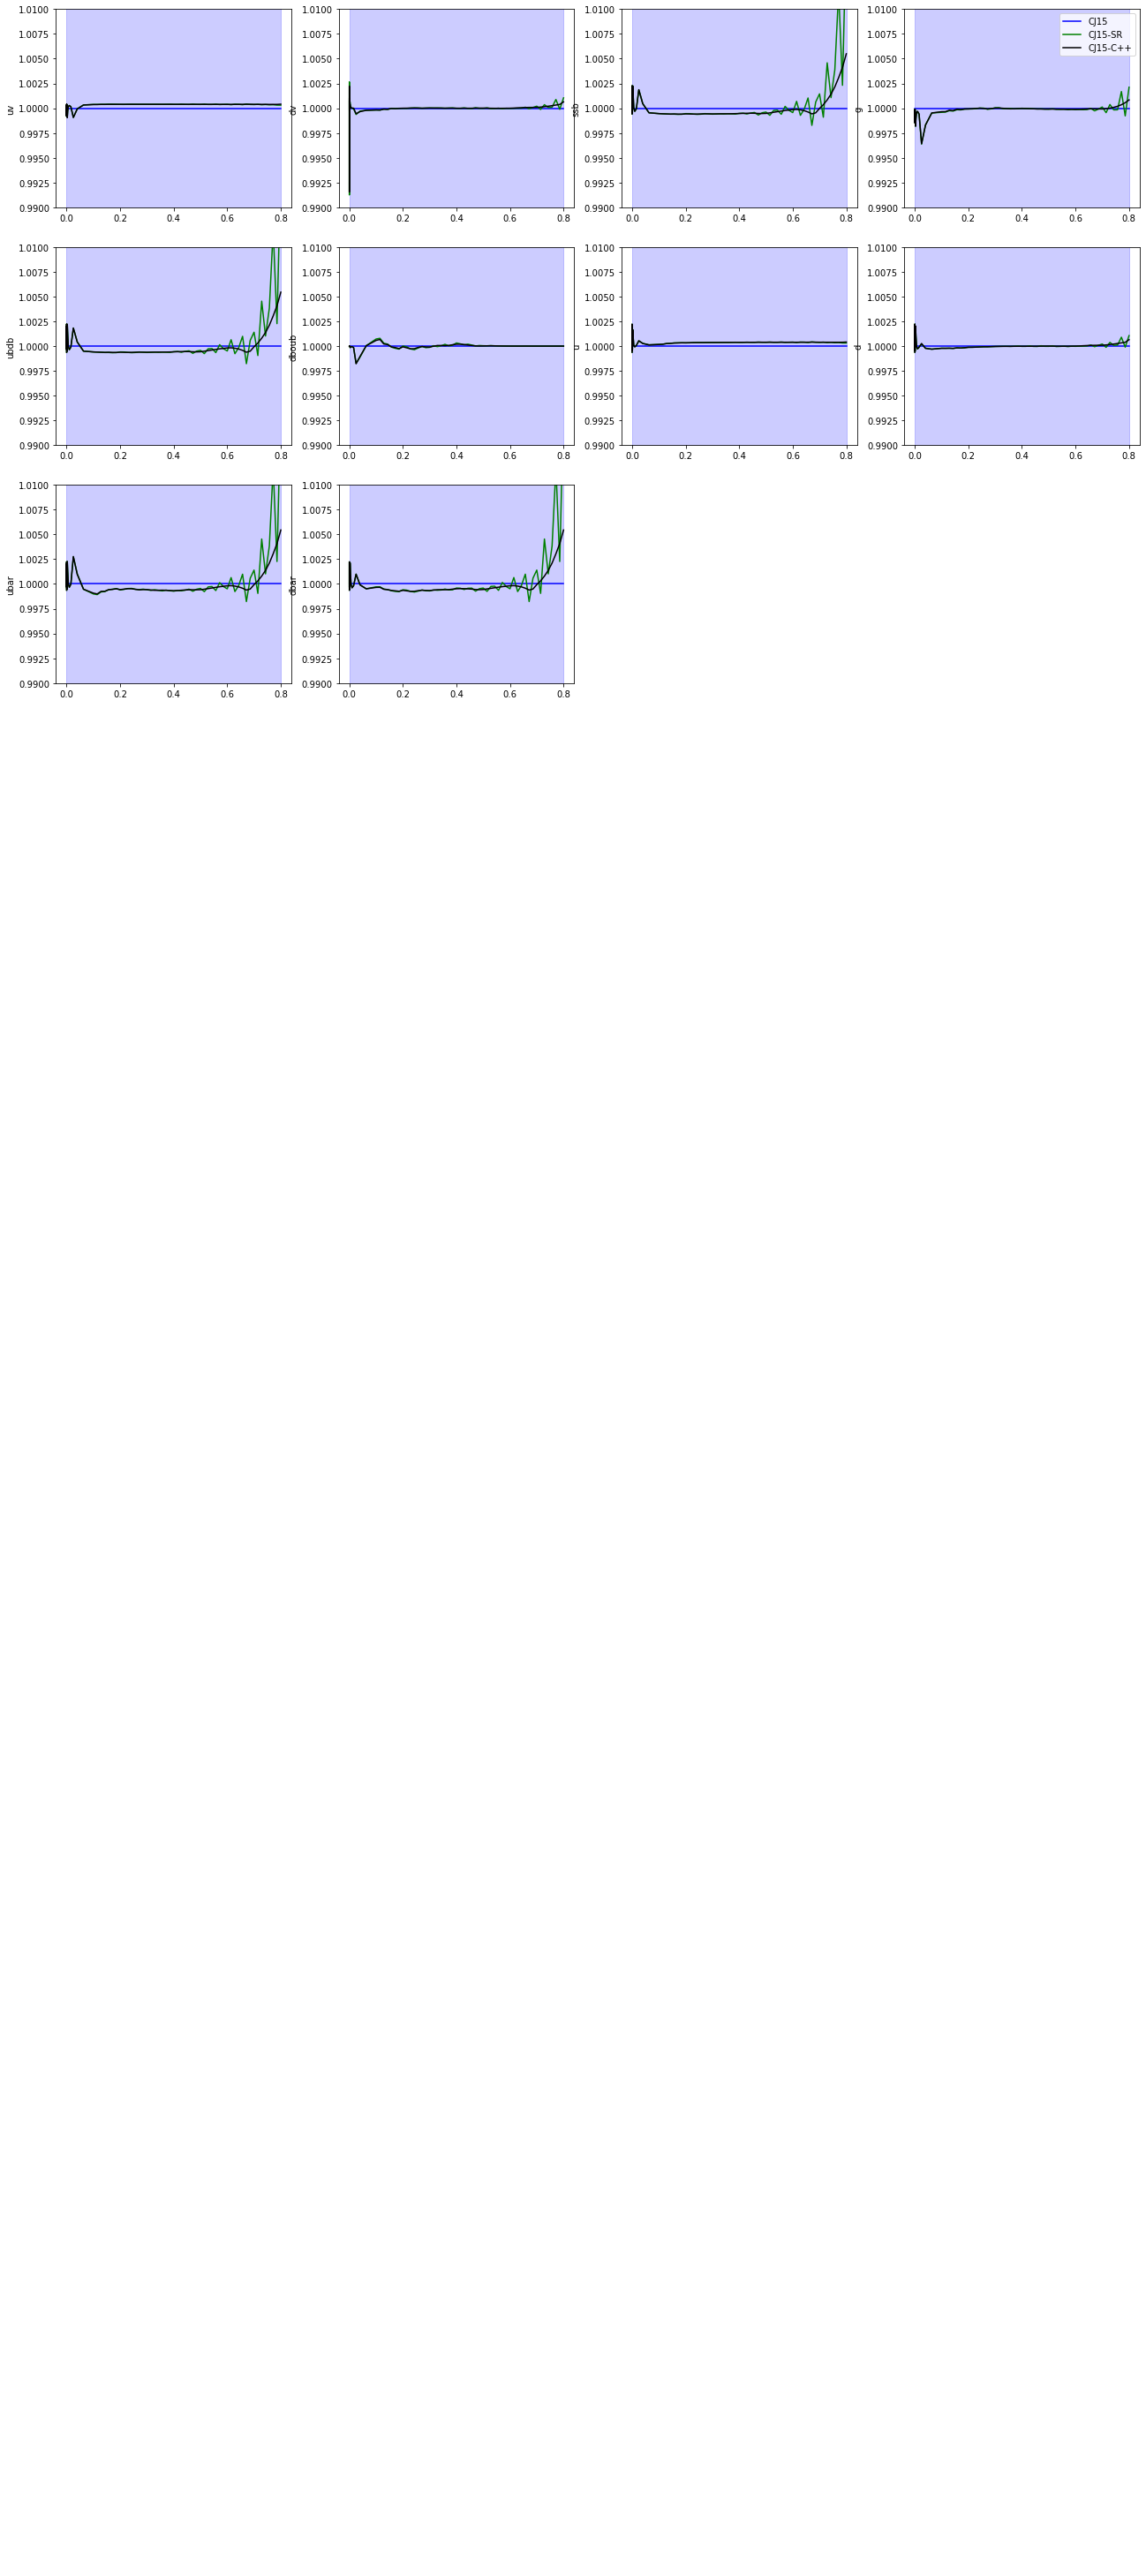

In [150]:
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
xlist_cj15 = cj15.xlist
ct14 =  PDFdata("CT14nlo_1_1", flvs=data_flv, xmin=1e-6) 
cj15_cpp =  PDFs("nCTEQ22_1_1", "sym", 1, 1, True)
xlist = cj15.xlist
xrbf = [1e-9, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,  0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]
plt.figure(figsize=[22, 19])
for i, flv in enumerate(data_flv) : 
    plt.subplot2grid((4,4), ( int(i/4), i%4), )
    data = cj15.data[flv][0]
    err = cj15.data[flv][1]
    data_denom=data


    plt.plot(xlist, data/data_denom, color="blue", label="CJ15")
    plt.fill_between(xlist, (data+err)/data_denom, (data-err)/data_denom, color="blue", alpha=0.2)

    """ 
    data_rbf = np.array([ct18.getPDFatInput(x, flv) for x in xrbf])
    rbf =  interp1d(xrbf, data_rbf, kind='quadratic',)#, epsilon=3, function="thin_plate", smooth=1e-5) 

    xl = np.linspace(0.1, 0.99, 10
    rbf_pred = np.array([rbf(x) for x in xl])
    data_xl = np.array([ct18.getPDFatInput(x, flv) for x in xl])
    plt.plot(xl, rbf_pred/data_xl, color="black", linestyle="dashed", label="RBF")


    """
    
    data_cj15 = cj15.data[flv][0]
    data_ct14 = ct14.data[flv][0]
    theo_cj = np.array([paramCJ.getXF(x, flv) for x in xlist])
    theo_cj_nsr = np.array([paramCJ_nsr.getXF(x, flv) for x in xlist])
    data_cj15_cpp = cj15_cpp.getPDFerrors(xlist, 1.3, flv)[0]

    plt.plot(xlist, theo_cj/data_denom, color="green", label="CJ15-SR")
    #plt.plot(xlist,  theo_cj_nsr/data_denom, color="red", label="CJ15-NSR")
    plt.plot(xlist, data_cj15_cpp/data_denom, color="black", label="CJ15-C++")
    
    plt.annotate(flv,xy=(0.05, 0.8), fontsize=20)
    
    #plt.xscale("log")
    if flv=="g" : 
        plt.legend()
    #plt.xlim([0.0001, 0.99])
    plt.ylim([0.99, 1.01])
    plt.ylabel(flv)
#plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("CJ15.pdf", bbox_inches="tight")

In [13]:
fitParams_cj

array([ 6.20829123e-01,  3.52482932e+00, -9.22045083e-02,  3.20009818e+00,
        5.48090491e-01,  3.81483716e+00,  3.01016559e+05, -2.75929969e+05,
        3.83173947e-01,  6.76681196e-01,  6.60476831e+00, -3.37312703e+00,
        3.21632183e+00, -1.96926229e-01,  8.40602294e+00, -9.15911942e-01,
        1.51977644e+01,  5.61493965e-01, -2.25709671e-01,  6.32603941e+00,
        1.15843215e+01, -1.31519783e+01, -1.01369825e+01,  5.84534640e+03,
        6.17349264e+02,  1.13302086e+01,  7.39872746e+00])

In [43]:
paramDict={
            "uv1":0.63002, "uv2" : 2.93351, "uv3":-2.36916, "uv4":1.26642, "uv5" : 1.71840,
            "dv1":0.51328, "dv2" : 4.21144, "dv3": -2.37454, "dv4":0.96497, "dv5" : 3.0,
            "gsum":0.38232, "g1":0.52256, "g2" : 3.03369, "g3": 4.39448, "g4":2.35917, "g5": -3.00000,
            "ubdb1":-0.32390, "ubdb2" :8.11550, "ubdb3": 0.41321, "ubdb4":4.75394, "ubdb5" :0.61366,
            "ssbsum":0.5, "ssb1":-0.32390, "ssb2" : 8.11550, "ssb3": 0.41321, "ssb4":4.75394, "ssb5" :  0.61366, 
            "dboub0":10.07478, "dboub1" :4.95673, "dboub2": 15.16661, "dboub3":17.00000, "dboub4" : 9.94806
        }
print(list(paramDict.values()))

[0.63002, 2.93351, -2.36916, 1.26642, 1.7184, 0.51328, 4.21144, -2.37454, 0.96497, 3.0, 0.38232, 0.52256, 3.03369, 4.39448, 2.35917, -3.0, -0.3239, 8.1155, 0.41321, 4.75394, 0.61366, 0.5, -0.3239, 8.1155, 0.41321, 4.75394, 0.61366, 10.07478, 4.95673, 15.16661, 17.0, 9.94806]


In [186]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [187]:
X, y = make_regression(n_samples=200, random_state=1)

In [17]:
XL= "1.00000E-06 1.28121E-06 1.64152E-06 2.10317E-06 2.69463E-06 3.45242E-06 4.42329E-06 5.66715E-06 7.26076E-06 9.30241E-06 1.19180E-05 1.52689E-05 1.95617E-05 2.50609E-05 3.21053E-05 4.11287E-05 5.26863E-05 6.74889E-05 8.64459E-05 1.10720E-04 1.41800E-04 1.81585E-04 2.32503E-04 2.97652E-04 3.80981E-04 4.87518E-04 6.26039E-04 8.00452E-04 1.02297E-03 1.30657E-03 1.66759E-03 2.12729E-03 2.71054E-03 3.44865E-03 4.37927E-03 5.54908E-03 7.01192E-03 8.83064E-03 1.10763E-02 1.38266E-02 1.71641E-02 2.11717E-02 2.59364E-02 3.15062E-02 3.79623E-02 4.53425E-02 5.36750E-02 6.29705E-02 7.32221E-02 8.44039E-02 9.64793E-02 1.09332E-01 1.23067E-01 1.37507E-01 1.52639E-01 1.68416E-01 1.84794E-01 2.01731E-01 2.19016E-01 2.36948E-01 2.55242E-01 2.73927E-01 2.92954E-01 3.12340E-01 3.32036E-01 3.52019E-01 3.72282E-01 3.92772E-01 4.13533E-01 4.34326E-01 4.55495E-01 4.76836E-01 4.98342E-01 5.20006E-01 5.41818E-01 5.63773E-01 5.85861E-01 6.08077E-01 6.30459E-01 6.52800E-01 6.75387E-01 6.98063E-01 7.20830E-01 7.43683E-01 7.66623E-01 7.89636E-01 8.12791E-01 8.35940E-01 8.59175E-01 8.82485E-01 9.05866E-01 9.29311E-01 9.52817E-01 9.76387E-01 1.00000E+00"

In [18]:
xsplit = XL.split(" ")
xs = []
for x in xsplit : 
    xs.append(float(x))

for x in xs : 
    print(x, end= ", ")

1e-06, 1.28121e-06, 1.64152e-06, 2.10317e-06, 2.69463e-06, 3.45242e-06, 4.42329e-06, 5.66715e-06, 7.26076e-06, 9.30241e-06, 1.1918e-05, 1.52689e-05, 1.95617e-05, 2.50609e-05, 3.21053e-05, 4.11287e-05, 5.26863e-05, 6.74889e-05, 8.64459e-05, 0.00011072, 0.0001418, 0.000181585, 0.000232503, 0.000297652, 0.000380981, 0.000487518, 0.000626039, 0.000800452, 0.00102297, 0.00130657, 0.00166759, 0.00212729, 0.00271054, 0.00344865, 0.00437927, 0.00554908, 0.00701192, 0.00883064, 0.0110763, 0.0138266, 0.0171641, 0.0211717, 0.0259364, 0.0315062, 0.0379623, 0.0453425, 0.053675, 0.0629705, 0.0732221, 0.0844039, 0.0964793, 0.109332, 0.123067, 0.137507, 0.152639, 0.168416, 0.184794, 0.201731, 0.219016, 0.236948, 0.255242, 0.273927, 0.292954, 0.31234, 0.332036, 0.352019, 0.372282, 0.392772, 0.413533, 0.434326, 0.455495, 0.476836, 0.498342, 0.520006, 0.541818, 0.563773, 0.585861, 0.608077, 0.630459, 0.6528, 0.675387, 0.698063, 0.72083, 0.743683, 0.766623, 0.789636, 0.812791, 0.83594, 0.859175, 0.882485,

In [19]:
len(xs)


95

In [ ]:
parName = [
        'uv1', 'uv2', 'uv3', 'uv4', 'uv5', 
        'dv1', 'dv2', 'dv3', 'dv4', 'dv5', 
        'gsum', 'g1', 'g2', 'g3', 'g4', 'g5',
         'ubdb1', 'ubdb2', 'ubdb3', 'ubdb4', 'ubdb5', 
         'ssbsum', 'ssb1', 'ssb2', 'ssb3', 'ssb4', 'ssb5',
          'dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4']
parVal =[  0.58548434,   3.02430526,  -3.40345705,   0.81209935,
         3.22115537,   0.64064233,   2.94284716, -19.5171162 ,
        -0.82452876,  47.93094122,   0.39028395,   0.40258985,
         6.8401196 ,  16.71164947,   1.39709066,  -7.33133226,
        -0.17255835,   5.51676097,  -2.18902863,   4.34714483,
         0.30650973,   0.4849825 ,  -0.08425687,  16.75963656,
        12.6947026 ,  11.69188116,  -0.15743712,   0.54212493,
         2.10409142,   0.13261703,   9.03566941,   3.84404106]

#data_flv = ["uv", "dv", "ubdb", "ssb", "g",  "dboub", "ub", "db", "u", "d"]
#ct18 = PDFdata("CT18NLO_1_1", flvs=data_flv, xmin=1e-6)
paramCTEQ = CTEQParam()
paramCTEQ.setParameter(parName, parVal)
oplist = parName#['dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4']
init = parVal#[ 0.0  ,  4.0249 , 2. , 1.8 , 0.6 ]
#init = scipy.optimize.Bounds ([0, -5, -50, -50, -100], [10, 5,50, 50, 100])  #[(0.0, 10.0), (-5.5), (-50,50), (-50, 50), (-100,100)]

chi2= Chi2Fit(cj15, paramCTEQ, oplist)
fitParams_cteq=chi2.fit(init, True,   local=True)